## Vectorozied Backtester

In [9]:
import pandas as pd
from abc import ABCMeta, abstractmethod

In [10]:
# df = pd.read_csv('data/rb.csv').set_index('datetime')
# df.index = pd.to_datetime(df.index)
df = pd.read_csv('data/IF2004_20200417.zip', index_col='datetime')

In [11]:
initial_capital = 1e4
multiplier=10
# Calculate moving average
df['MA5'] = df.close.rolling(window=5).mean()
df['MA20'] = df.close.rolling(window=20).mean()
# Generate position by comparing MA5 and MA20
df['Position'] = [0 if isna else 1 if ge else -1 for (isna, ge) in zip(df['MA5'].isna() | df['MA20'].isna(), df['MA5'] >= df['MA20'])]
# df['Position'] = df['Position'].shift().fillna(0)
# # Calculate Trade and Position P&L
df['TradeP&L'] = (df['close'] - df['close'].shift(1)) * (df['Position'].shift(1) - df['Position']) * multiplier
df['TradeP&L'] = df['TradeP&L'].fillna(0)
df['PositionP&L'] = (df['close'] - df['close'].shift(1)) * df['Position'] * multiplier
df['PositionP&L'] = df['PositionP&L'].fillna(0)
df['CumP&L'] = (df['TradeP&L'] + df['PositionP&L']).cumsum()
df['Capital'] = (initial_capital + df['CumP&L'])
# # Calculate returns 
df['Return'] = (df['Capital'] - df['Capital'].shift()) / df['Capital'].shift()
df['Return'] = df['Return'].fillna(0)
# # Method1: calculate NAV by multiplication of returns
df['NetAssetValue'] = (1 + df['Return']).cumprod()
# # Method2: calculate NAV by divide by initial capital
df['NetAssetValue2'] = df['Capital'] / initial_capital

df

,close,MA5,MA20,Position,TradeP&L,PositionP&L,CumP&L,Capital,Return,NetAssetValue,NetAssetValue2
datetime,,,,,,,,,,,
2020-04-17 09:29:00,3832.0,NaN,NaN,0,0.0,0.0,0.0,10000.0,0.000000,1.0000,1.0000
2020-04-17 09:30:00,3830.0,NaN,NaN,0,-0.0,-0.0,0.0,10000.0,0.000000,1.0000,1.0000
2020-04-17 09:31:00,3829.4,NaN,NaN,0,-0.0,-0.0,0.0,10000.0,0.000000,1.0000,1.0000
2020-04-17 09:32:00,3830.4,NaN,NaN,0,0.0,0.0,0.0,10000.0,0.000000,1.0000,1.0000
2020-04-17 09:33:00,3828.8,3830.12,NaN,0,-0.0,-0.0,0.0,10000.0,0.000000,1.0000,1.0000
...,...,...,...,...,...,...,...,...,...,...,...
2020-04-17 14:55:00,3850.0,3850.16,3850.22,-1,-0.0,2.0,126.0,10126.0,0.000198,1.0126,1.0126
2020-04-17 14:56:00,3849.8,3850.08,3850.18,-1,-0.0,2.0,128.0,10128.0,0.000198,1.0128,1.0128
2020-04-17 14:57:00,3849.8,3850.04,3850.18,-1,0.0,-0.0,128.0,10128.0,0.000000,1.0128,1.0128


In [12]:
precision=9
# df2 = pd.read_csv('data/NaiveExcelBacktester.csv').set_index('datetime').drop(columns=['MA5 >= MA20'])
df2 = pd.read_csv('data/IF2004_20200417Backtester.CSV').set_index('datetime').drop(columns=['MA5 >= MA20'])
df2.index = pd.to_datetime(df2.index)

# list(zip(df['TradeP&L'], df2['TradeP&L']))
cmp_result = (df.isna() & df2.isna()) | ((df - df2).abs().round(precision) == 0)
print('all true: ', cmp_result.all().all())
cmp_result.describe()

all true:  True


,close,MA5,MA20,Position,TradeP&L,PositionP&L,CumP&L,Capital,Return,NetAssetValue,NetAssetValue2
count,197,197,197,197,197,197,197,197,197,197,197
unique,1,1,1,1,1,1,1,1,1,1,1
top,True,True,True,True,True,True,True,True,True,True,True
freq,197,197,197,197,197,197,197,197,197,197,197


## BackTest

In [13]:
class DataHandler:
    def __init__(self, start_date=None, end_date=None, symbol=None, contract=None):
        self.start_date = start_date
        self.end_date = end_date
        self.symbol = symbol
        self.contract = contract

    def load(self):
        """Load data
        Multiple csv file, append them
        """
        df = pd.read_csv('./data/IF2004_20200417_1min.zip',index_col='datetime')
        return df
        

In [6]:
class BackTest:
    __metaclass__ = ABCMeta

    def __init__(self, symbol, data=None):
        self.data = data.copy()  # use copy method to reduce times of loading data file
        self.df = pd.DataFrame(index=data.index, columns=['close', 'signal', 'position'])
        self.symbol = symbol.lower() if isinstance(symbol, str) else symbol
        self.df.close = self.data.close

    @abstractmethod
    def generate_signal(self):
        raise NotImplementedError('Should implement generate signal method!')

    def get_commission_rate(self):
        return 0.0001

    def get_multiplier(self):
        multiplier_dict = {'rb': 10, 'if':10}
        return multiplier_dict[self.symbol]

    def generate_position(self):
        self.generate_signal()
        self.df.loc[self.df.signal >= 0, 'position'] = 1
        self.df.loc[self.df.signal < 0, 'position'] = -1

        # self.df.loc[self.df.signal > 0, 'position'] = 1
        # self.df.loc[self.df.signal < 0, 'position'] = -1
        # self.df.loc[self.df.signal == 0, 'position'] = 0

    def calculate_performance(self):
        self.generate_position()  # default 0 -1 1 can be set in other format

        commission_rate = self.get_commission_rate()
        multiplier = self.get_multiplier()

        self.df.position = self.df.position.shift().fillna(0)  # shift position
        self.df['trade'] = (self.df.position - self.df.position.shift()).fillna(0)

        # limit up and down happends if and only if ask==bid
        # tag as bad bar if it happens at bar open or close
        good_bar = (self.data.open_bid_price1 < self.data.open_ask_price1) & (
                    self.data.close_bid_price1 < self.data.close_ask_price1)
        good_buy = (self.df.trade > 0) & good_bar
        good_sell = (self.df.trade < 0) & good_bar
        bad_buy_or_sell = (self.df.trade != 0) & ((self.data.close_bid_price1 == self.data.close_ask_price1) | (
            self.data.open_bid_price1 == self.data.open_ask_price1))

        self.good_bar = good_bar
        self.good_buy = good_buy
        self.good_sell = good_sell
        self.bad_buy_or_sell = bad_buy_or_sell
        self.df.loc[bad_buy_or_sell, 'tradeprice'] = self.data.loc[bad_buy_or_sell, 'close']
        self.df.loc[good_buy, 'tradeprice'] = self.data.loc[good_buy, 'open_ask_price1']
        self.df.loc[good_sell, 'tradeprice'] = self.data.loc[good_sell, 'open_bid_price1']

        self.df['tradepnl'] = ((self.df.close.shift(1) - self.df.tradeprice) * self.df.trade).fillna(0) * multiplier
        self.df['pospnl'] = ((self.df.close - self.df.close.shift(1)) * self.df.position).fillna(0) * multiplier
        self.df['barpnl'] = self.df.pospnl + self.df.tradepnl
        self.df['cumpnl'] = self.df.barpnl.cumsum()

In [14]:
class NaiveMA(BackTest):
    def __init__(self, symbol, data):
        super(NaiveMA, self).__init__(symbol, data)
    
    def generate_signal(self):
        """ Your code here
        """
        MA5 = self.df.close.rolling(window=5).mean()
        MA20 = self.df.close.rolling(window=20).mean()
        self.df['signal'] = [0 if isna else 1 if ge else -1 for (isna, ge) in zip(MA5.isna() | MA20.isna(), MA5 >= MA20)]

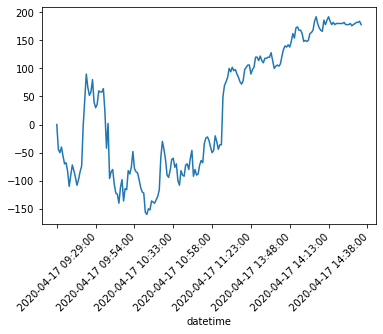

In [15]:
data_handler = DataHandler()
data = data_handler.load()
moving_average_test = NaiveMA('IF', data)
moving_average_test.calculate_performance()
ax = moving_average_test.df.cumpnl.plot()
ax.xaxis.set_tick_params(rotation=45, labelsize=10)